In [1]:
%time
%load_ext autotime
%load_ext autoreload
%autoreload 2


# if cannot import the modules, add the parent directory to system path might help

import os, tqdm, sys
parent_dir = os.path.abspath(os.getcwd()+'/..')+'/'
sys.path.append(parent_dir)

from utils.save import make_dir, save_pickle, load_pickle, save
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import re
import tqdm
import json

import random
random_seed = 2019

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs


load data, usually takes 2 minutes

In [ ]:
data = load_pickle('../big_data/recipe1M_ny.pickle')
layer1 = json.load(open('/data/yueliu/RecipeAnalytics_201906/raw_data/recipe1M/layer1.json','r'))

use rule-based methods to clean the data

In [3]:
start_with = ['tbsp','pkt','g','tsp','x','cups','oz','mrs','can',
              'lb', 'pkg','tbsp','lbs','qt','lrg','grams','sm',
              'cans','bottle','and','cubes','o',',','handful',
              'container','t','bag',
              'gram','jar','c','lg','ml','ounces','ounce','box']

remove = ['%s.' %str(i) for i in range(30)]

def clean_line(line):
    '''
    Args:
        line: a string, such as food name, sentences...
    '''
    assert type(line) == str
    
    # all lowercase
    line = line.lower()
    
    line = line.replace(' .', '.')
    line = line.replace(' !', '!')
    line = line.replace(')', '')
    line = line.replace('*', '')
    line = line.replace('..', '.')
    line = line.replace(' - ', '')
    
    # only reserve number and alphabets
    line = re.sub(r"[^a-z0-9+()-/?&'!.,]", ' ', line)
    
    # replace things in brace
    line = re.sub(r'\([^)]*\)', '', line)
    
    # remove extra spaces
    line = re.sub(' +',' ',line).strip()
    
    return line

def clean_prefix(ingr):
    cleaned = []
    for ans in ingr:
        # strip
        ans = re.sub(' +',' ',ans).strip()
        # remove number
        ans = re.sub(r'\d+', '', ans)
        # remove period
        ans = ans.replace('.', '')
        
        # remove prefixes
        for prefix in start_with:
            ans = re.sub('^'+prefix+'\s', '', ans)
        # strip again
        ans = re.sub(' +',' ',ans).strip()
        
        if ans:
            cleaned.append(ans)
            
    return cleaned

time: 21.1 ms


this processs usually takes <1 hr

In [4]:
lst_undetectable = []
new_data = []

for i, v in tqdm.tqdm(enumerate(data)):
    '''
    1. dealing with undetectable cases
    '''
    ingr = []
    for ny_full_ingredients in v['ny_full_ingredients']:
        if 'half and half' in ny_full_ingredients['input']:
            ingr.append('half and half')
        elif 'purpose flour' in ny_full_ingredients['input']:
            ingr.append('all purpose flour')
            
        elif type(ny_full_ingredients['name'])==float:
            ans = ''
            for word in ['salt', 'sugar', 'oil','mustard','water',
                         'steak','nuts','butter','garnish','ketchup',
                         'milk','mayonnaise','pepper','cumin', 'rice',
                         'seasoning','grated parmesan','raisin','olive oil',
                         'stuffing mix', 'sauce','syrup','mushroom soup',
                         'white sugar','brown sugar',
                         'chopped onions','sour cream','lean ground beef','tortilla',
                         'cayenne','paprika','corn', 'egg yolks', 'egg whites'
                         'condensed milk',
                         'crumb crust','jell o vanilla flavor instant pudding']:
                if word in ny_full_ingredients['input']:
                    ans = word
                    
            if ',' in ny_full_ingredients['input'] and not ans:
                ans = ny_full_ingredients['input'].split(',')[0]
                ans = ans if ans.count(' ') ==0 else ''
            
            if ans:
                ingr.append(ans)
            else:
                lst_undetectable.append(ny_full_ingredients['input'])
        
        elif 'recipe' not in ny_full_ingredients['name']:
            ans = ny_full_ingredients['name']
            ingr.append(ans)
    '''
    2. cleaning instruction
    '''
    instr = ''
    # drop numbered list
    instr = [line['text'] for line in layer1[i]['instructions'] if line['text'] not in remove]
    instr = [line[:-2] if line[-2:] in remove else line for line in instr]
    instr = [line[2:] if line[:2] in remove else line for line in instr]
    instr = [line for line in instr if line]
    # add period for certain sentences
    instr = [line+'.' if line[-1] not in ['!', '.', ';',','] else line for line in instr]
    # clean braces
    instr = ' '.join(instr)
    instr = clean_line(instr)
    
    # contain calorie info
    if 'calorie' in instr:
        for term in ['per serving','nutrition information','servings','each serving has','per slice','calories']:
            instr, sep, tail = instr.partition(term)
        if not instr.endswith('.'):
            instr, sep, tail = instr.rpartition('.')
            instr = instr+sep
            
    # contain author info
    instr, sep, tail = instr.partition('recipe from new new')
    
    tit = clean_line(v['title'])
    
    # long enough
    cond1 = (len(ingr) == len(v['ny_full_ingredients']))
    cond2 = (instr.count('.') + instr.count('!') >=2)
    cond3 = (len(instr.split(' '))>10)
    cond4 = (i!=8219)
             
    if cond1 and cond2 and cond3 and cond4:
        '''
        3. cleaning mistakes of ny-times-parser
        '''
        ingr = clean_prefix(ingr)
        ingr = clean_prefix(ingr)
        ingr = list(set(ingr))
        
        if len(ingr)>=2 and '. 1 tablespoon' not in instr and '. 2 tablespoons' not in instr:
            
            recipe = {'ingredients':ingr, 'title':tit, 
                      'instructions': instr, 'recipe1m_idx': i, 'url': layer1[i]['url']
                     }
            new_data.append(recipe)

1029720it [23:27, 731.37it/s]

time: 23min 27s


In [5]:
save_pickle(obj = new_data, filename='../big_data/data_1218.pickle',overwrite=True)

time: 7.06 s


In [8]:
data = new_data
len(data)/len(layer1)

0.8782979839179583

time: 12.3 s


In [2]:
data = load_pickle(filename='../big_data/data_1218.pickle')

time: 6.99 s


### Make data loading faster

In [9]:
cd /data/yueliu/RecipeAnalytics_201906

/data/yueliu/RecipeAnalytics_201906
time: 18.1 ms


In [10]:
import os, importlib
save = importlib.import_module("gpt-2.src.save")
to_write = "path = '/data/yueliu/RecipeAnalytics_201906/gpt-2/'"+'\n'+"path_to_model = path + 'models/'"
save.save('gpt-2/src/path.py', to_write, overwrite = True)

saved gpt-2/src/path.py
time: 17.4 ms


In [10]:
cd gpt-2

/data/yueliu/RecipeAnalytics_201906/gpt-2
time: 36.4 ms


In [12]:
from src import encoder
enc = encoder.get_encoder('117M')

time: 120 ms


In [4]:
def txt(v, fields, mode = 'train'):
    '''
    fields: an order list, the last is the field to predict
    mode: test/train, return string X, y or X+y
    '''
    to_write = ''
    for field in fields:
        if field == 'title':
            name = v['title']
            to_write += ' <start-title>'+name+' <end-title>'
        if field == 'ingredients':
            ingredients = v['ingredients']
            to_write += ' <start-ingredients>'+'$'.join(ingredients)+'$ <end-ingredients>'
        if field == 'directions':
            directions = v['instructions']
            to_write += ' <start-directions>'+ directions +' <end-directions>'
            
    if mode == 'train':
        return to_write
                                                     
    elif mode == 'test':
        field_to_predict = '<start-%s>'%fields[-1]
        to_X, to_y = to_write.split(field_to_predict)
        return to_X+field_to_predict, to_y

class to_gpt2:
    def __init__(self, data, ls = None):
        if not ls:
            ls = list(range(len(data)))
        random.seed(random_seed)
        random.shuffle(ls)
        self.ls_test = ls[:4000] 
        self.ls_val = ls[4000:8000]
        self.ls_train = ls[8000:]
        self.data = data
        
    def train(self, ls, filename, overwrite = False, is_val = False):
        to_write = ''
        for i, v in tqdm.tqdm(enumerate(self.data)):
            if i in ls:      
                self.save(filename+'%d'%(i)+'d.txt', txt(v, ['title','ingredients','directions']), overwrite)
                self.save(filename+'%d'%(i)+'i.txt', txt(v, ['title','directions','ingredients']), overwrite)
                self.save(filename+'%d'%(i)+'t.txt', txt(v, ['ingredients','directions','title']), overwrite)
                
    def train_reduce(self, ls, filename, overwrite = False, is_val = False):
        '''
        corresponding to the changed gpt-2:
        it reduces the memory usuage by changing the sampling of training data
        '''
        to_write = ''
        for i, v in tqdm.tqdm(enumerate(self.data)):
            if i in ls:      
                self.save(filename+'%d'%(i)+'d.txt', txt(v, ['title','ingredients','directions']), overwrite)
                
    def test(self, ls, filename, overwrite = False, is_val = False):
        to_write = ''
        for i, v in tqdm.tqdm(enumerate(self.data)):
            if i in ls:
                self.save(filename+'X/%d'%(i)+'d.txt', txt(v, ['title','ingredients','directions'], mode = 'test')[0], overwrite)
                self.save(filename+'X/%d'%(i)+'i.txt', txt(v, ['title','directions','ingredients'], mode = 'test')[0], overwrite)
                self.save(filename+'X/%d'%(i)+'t.txt', txt(v, ['ingredients','directions','title'], mode = 'test')[0], overwrite)
                
                self.save(filename+'y/%d'%(i)+'d.txt', txt(v, ['title','ingredients','directions'], mode = 'test')[1], overwrite)
                self.save(filename+'y/%d'%(i)+'i.txt', txt(v, ['title','directions','ingredients'], mode = 'test')[1], overwrite)
                self.save(filename+'y/%d'%(i)+'t.txt', txt(v, ['ingredients','directions','title'], mode = 'test')[1], overwrite)
        
    def save(self, filename, to_write, overwrite = False):
        make_dir(filename)
        if os.path.isfile(filename) == True and overwrite == False:
            print('already exists'+filename)
        else:    
            with open(filename,'w') as f:
                f.write('%s' % to_write)
                
    def make_chunk(self, ls, filename, tag, overwrite = False):
        chunk = []
        for i, v in tqdm.tqdm(enumerate(self.data)):
            if i in ls:      
                chunk.append(self.encode_recipe(self.data[i]))
        make_dir(filename)
        print(filename+tag)
        save_pickle(filename+tag, chunk)
        
    def encode_recipe(self,recipe):
        return enc.encode(txt(recipe, ['title','ingredients','directions']))
    
    def fast_chunk(self, filename, overwrite = False):
        self.make_chunk(self.ls_train, filename, tag = 'chunk.train')
        self.make_chunk(self.ls_val, filename, tag = 'chunk.val')
        self.make_chunk(self.ls_test, filename, tag = 'chunk.test')

time: 31 ms


In [11]:
model = to_gpt2(data)
filename = '../to_gpt2/recipe1M_1218/'

time: 1.05 s


In [15]:
model.test(model.ls_val, filename+'val/', overwrite = True)

974it [00:00, 9739.01it/s]

make dir
make dir


904401it [01:45, 8594.36it/s]

time: 1min 45s


In [12]:
model.test(model.ls_test, filename+'test/', overwrite = True)

1724it [00:00, 7532.75it/s]

make dir
make dir


904401it [01:35, 9422.02it/s] 

time: 1min 36s


usually takes 15 hr

In [16]:
model.fast_chunk(filename)

904401it [10:14:32, 24.53it/s]


../to_gpt2/recipe1M_1218/chunk.train


904401it [02:58, 5057.83it/s]
552it [00:00, 5515.34it/s]

../to_gpt2/recipe1M_1218/chunk.val


904401it [02:54, 5188.45it/s]


../to_gpt2/recipe1M_1218/chunk.test
time: 10h 20min 35s


examine the results

In [18]:
X = load_pickle('../to_gpt2/recipe1M_1218/chunk.train')
distr_length = pd.Series([len(recipe) for recipe in X])

time: 14.3 s


max 3420 min 55


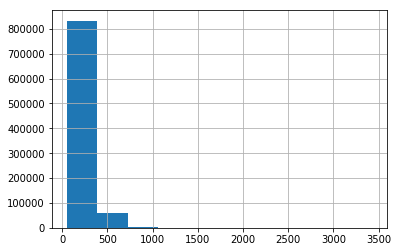

time: 259 ms


In [22]:
print('max',distr_length.max(),'min', distr_length.min())
display(distr_length.hist())

In [20]:
1 - sum(distr_length>512)/ len(distr_length)

0.9759214904936518

time: 123 ms


In [21]:
distr_length.mean(), distr_length.median(), distr_length.std()

(218.37602813919216, 192.0, 114.25804123120558)

time: 35.7 ms
